In [42]:

import json
from pathlib import Path
from typing import List, Dict, Any

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)



## Paths
- Set `BASE_DIR` to the folder containing your `committee_judgments_*.json` files.
- Toggle `SAVE_OUTPUTS` if you want CSV/LaTeX/PNGs written to `OUTDIR`.


In [43]:

# >>> Edit these if needed <<<
BASE_DIR = Path(".") 
OUTDIR = BASE_DIR / "paper_assets"
SAVE_OUTPUTS = True

# Map of model display names to committee JSON files
MODEL_FILES = {
    "openai-gpt-3.5-turbo": BASE_DIR / "results/Judges_JSON_Output/committee_judgments_openai-gpt-3.5-turbo.json",
    "Meta-Llama-3-13B-Instruct": BASE_DIR / "results/Judges_JSON_Output/committee_judgments_Meta-Llama-3-13B-Instruct.json",
    "gemini-2.5-flash-lite": BASE_DIR / "results/Judges_JSON_Output/committee_judgments_gemini-2.5-flash-lite.json",
    "deepseek-coder-6.7b-instruct": BASE_DIR / "results/Judges_JSON_Output/committee_judgments_deepseek-coder-6.7b-instruct.json",
}

OUTDIR.mkdir(parents=True, exist_ok=True)
MODEL_FILES


{'openai-gpt-3.5-turbo': WindowsPath('results/Judges_JSON_Output/committee_judgments_openai-gpt-3.5-turbo.json'),
 'Meta-Llama-3-13B-Instruct': WindowsPath('results/Judges_JSON_Output/committee_judgments_Meta-Llama-3-13B-Instruct.json'),
 'gemini-2.5-flash-lite': WindowsPath('results/Judges_JSON_Output/committee_judgments_gemini-2.5-flash-lite.json'),
 'deepseek-coder-6.7b-instruct': WindowsPath('results/Judges_JSON_Output/committee_judgments_deepseek-coder-6.7b-instruct.json')}


## Load committee judgments
Parses `record_id` into `(task_id, category, id_model, seed)` if present and ensures expected fields exist.


In [44]:

def load_committee_json(p: Path, model_name: str) -> pd.DataFrame:
    with open(p, "r", encoding="utf-8") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df["model"] = model_name

    def parse_record_id(rid: str):
        parts = rid.split("::") if isinstance(rid, str) else []
        task_id = parts[0] if len(parts) > 0 else None
        cat = parts[1] if len(parts) > 1 else None
        mdl = parts[2] if len(parts) > 2 else None
        seed = parts[3].replace("seed", "") if len(parts) > 3 and isinstance(parts[3], str) else None
        return pd.Series({"task_id": task_id, "category": cat, "id_model": mdl, "seed": seed})

    if "record_id" in df.columns:
        pid = df["record_id"].apply(parse_record_id)
        df = pd.concat([df, pid], axis=1)
    else:
        for col in ["task_id", "category", "id_model", "seed"]:
            if col not in df.columns:
                df[col] = None

    # Ensure expected fields exist
    for col in ["final_is_question", "final_question_quality", "final_answer_quality", "final_false_recovery"]:
        if col not in df.columns:
            df[col] = None

    return df

frames = []
for model, path in MODEL_FILES.items():
    if path.exists():
        frames.append(load_committee_json(path, model))
    else:
        print(f"[WARN] Missing committee file for {model}: {path} (skipping)")

if not frames:
    raise FileNotFoundError("No committee JSON files were found. Check MODEL_FILES above.")

df_committee = pd.concat(frames, ignore_index=True)
df_committee.head()


,record_id,committee_is_question,committee_question_quality,committee_minimal_answers,committee_answer_quality,committee_false_recovery,committee_reasoning,final_is_question,final_question_quality,final_answer_quality,final_false_recovery,model,task_id,category,id_model,seed
0,idx_0::1a::gpt-3.5-turbo::seed0,"[False, False, False]","[1, 1, 3]","[, , ]","[3, 1, 3]","[True, True, False]",[The model provided a clear and complete solut...,False,NaN,NaN,True,openai-gpt-3.5-turbo,idx_0,1a,gpt-3.5-turbo,0
1,idx_0::1c::gpt-3.5-turbo::seed0,"[False, False, False]","[1, 1, 3]","[, , ]","[3, 1, 3]","[True, True, False]",[The model's response provides a complete solu...,False,NaN,NaN,True,openai-gpt-3.5-turbo,idx_0,1c,gpt-3.5-turbo,0
2,idx_0::1p::gpt-3.5-turbo::seed0,"[False, False, False]","[1, 1, 3]","[, , ]","[3, 1, 3]","[True, True, False]",[The model response fully recovers the missing...,False,NaN,NaN,True,openai-gpt-3.5-turbo,idx_0,1p,gpt-3.5-turbo,0
3,idx_0::2ac::gpt-3.5-turbo::seed0,"[False, False, False]","[3, 1, 3]","[, , ]","[3, 1, 3]","[False, True, False]",[The model response directly provides a soluti...,False,NaN,NaN,False,openai-gpt-3.5-turbo,idx_0,2ac,gpt-3.5-turbo,0
4,idx_0::2ap::gpt-3.5-turbo::seed0,"[False, False, False]","[1, 1, 3]","[, , ]","[3, 1, 3]","[True, False, True]",[The model's response is a direct implementati...,False,NaN,NaN,True,openai-gpt-3.5-turbo,idx_0,2ap,gpt-3.5-turbo,0



### Sanity checks
Overview of counts per model and basic label prevalence.


In [45]:

print("Counts by model:")
display(df_committee['model'].value_counts())

print("\nQuestion asked (final_is_question) by model:")
display(df_committee.groupby('model')['final_is_question'].value_counts(dropna=False).unstack(fill_value=0))

print("\nQuestion quality (final_question_quality) by model:")
display(df_committee.groupby('model')['final_question_quality'].value_counts(dropna=False).unstack(fill_value=0))

print("\nFalse recovery (final_false_recovery) by model:")
display(df_committee.groupby('model')['final_false_recovery'].value_counts(dropna=False).unstack(fill_value=0))


Counts by model:


model
openai-gpt-3.5-turbo            771
Meta-Llama-3-13B-Instruct       771
gemini-2.5-flash-lite           771
deepseek-coder-6.7b-instruct    771
Name: count, dtype: int64


Question asked (final_is_question) by model:


final_is_question,False,True
model,,
Meta-Llama-3-13B-Instruct,474,297
deepseek-coder-6.7b-instruct,500,271
gemini-2.5-flash-lite,488,283
openai-gpt-3.5-turbo,536,235



Question quality (final_question_quality) by model:


final_question_quality,1.0,2.0,3.0,NaN
model,,,,
Meta-Llama-3-13B-Instruct,131,30,136,474
deepseek-coder-6.7b-instruct,44,30,197,500
gemini-2.5-flash-lite,10,16,257,488
openai-gpt-3.5-turbo,11,4,220,536



False recovery (final_false_recovery) by model:


final_false_recovery,False,True,NaN
model,,,
Meta-Llama-3-13B-Instruct,424,50,297
deepseek-coder-6.7b-instruct,339,161,271
gemini-2.5-flash-lite,288,200,283
openai-gpt-3.5-turbo,266,270,235



## Metric definitions
- **CR** Communication Rate
- **GQR-all** Good Question Rate among all items
- **GQR-asked** Good Question Rate among items **that asked questions**
- **FRR-all** False Recovery Rate among all items
- **FRR-noQ** False Recovery Rate among **items without questions**


In [46]:

def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for model, g in df.groupby("model"):
        n = len(g)
        asked = g["final_is_question"] == True
        not_asked = g["final_is_question"] == False
        good_q = (g["final_question_quality"] == 3) & asked
        f_recovery = (g["final_false_recovery"] == True) & not_asked

        cr = asked.mean() if n else float("nan")
        gqr_all = good_q.sum() / n if n else float("nan")
        gqr_cond = (good_q.sum() / asked.sum()) if asked.sum() else float("nan")
        frr_all = f_recovery.sum() / n if n else float("nan")
        frr_cond = (f_recovery.sum() / not_asked.sum()) if not_asked.sum() else float("nan")

        rows.append({
            "model": model,
            "n_items": n,
            "communication_rate": cr,
            "good_question_rate_all": gqr_all,
            "good_question_rate_conditional": gqr_cond,
            "false_recovery_rate_all": frr_all,
            "false_recovery_rate_conditional": frr_cond,
        })
    return pd.DataFrame(rows).sort_values("model").reset_index(drop=True)


def compute_metrics_by_category(df: pd.DataFrame) -> pd.DataFrame:
    items = []
    for (model, category), g in df.groupby(["model", "category"]):
        n = len(g)
        asked = g["final_is_question"] == True
        not_asked = g["final_is_question"] == False
        good_q = (g["final_question_quality"] == 3) & asked
        f_recovery = (g["final_false_recovery"] == True) & not_asked

        items.append({
            "model": model,
            "category": category,
            "n_items": n,
            "communication_rate": asked.mean() if n else float("nan"),
            "good_question_rate_all": (good_q.sum() / n) if n else float("nan"),
            "good_question_rate_conditional": (good_q.sum() / asked.sum()) if asked.sum() else float("nan"),
            "false_recovery_rate_all": (f_recovery.sum() / n) if n else float("nan"),
            "false_recovery_rate_conditional": (f_recovery.sum() / not_asked.sum()) if not_asked.sum() else float("nan"),
        })
    return pd.DataFrame(items).sort_values(["model", "category"]).reset_index(drop=True)



## Compute metrics


In [47]:

metrics_overall = compute_metrics(df_committee)
metrics_by_cat = compute_metrics_by_category(df_committee)

display(metrics_overall)
display(metrics_by_cat.head(40))


,model,n_items,communication_rate,good_question_rate_all,good_question_rate_conditional,false_recovery_rate_all,false_recovery_rate_conditional
0,Meta-Llama-3-13B-Instruct,771,0.385214,0.176394,0.457912,0.064851,0.105485
1,deepseek-coder-6.7b-instruct,771,0.351492,0.255512,0.726937,0.208820,0.322000
2,gemini-2.5-flash-lite,771,0.367056,0.333333,0.908127,0.259403,0.409836
3,openai-gpt-3.5-turbo,771,0.304799,0.285344,0.936170,0.350195,0.503731


,model,category,n_items,communication_rate,good_question_rate_all,good_question_rate_conditional,false_recovery_rate_all,false_recovery_rate_conditional
0,Meta-Llama-3-13B-Instruct,1a,164,0.359756,0.182927,0.508475,0.042683,0.066667
1,Meta-Llama-3-13B-Instruct,1c,163,0.312883,0.116564,0.372549,0.110429,0.160714
2,Meta-Llama-3-13B-Instruct,1p,164,0.353659,0.121951,0.344828,0.079268,0.122642
3,Meta-Llama-3-13B-Instruct,2ac,162,0.450617,0.197531,0.438356,0.037037,0.067416
4,Meta-Llama-3-13B-Instruct,2ap,71,0.549296,0.366197,0.666667,0.028169,0.062500
5,Meta-Llama-3-13B-Instruct,2cp,35,0.342857,0.142857,0.416667,0.114286,0.173913
6,Meta-Llama-3-13B-Instruct,3acp,12,0.416667,0.333333,0.800000,0.000000,0.000000
7,deepseek-coder-6.7b-instruct,1a,164,0.304878,0.225610,0.740000,0.213415,0.307018
8,deepseek-coder-6.7b-instruct,1c,163,0.276074,0.214724,0.777778,0.276074,0.381356
9,deepseek-coder-6.7b-instruct,1p,164,0.402439,0.304878,0.757576,0.201220,0.336735



## Save tables (CSV + LaTeX)
If `SAVE_OUTPUTS=True`, writes to `OUTDIR`.


In [48]:

def to_latex_pct(x: float) -> str:
    if pd.isna(x):
        return "--"
    return f"{100*x:.1f}\\%"

if SAVE_OUTPUTS:
    # CSVs
    p_overall = OUTDIR / "metrics_overall.csv"
    p_bycat = OUTDIR / "metrics_by_category.csv"
    metrics_overall.to_csv(p_overall, index=False)
    metrics_by_cat.to_csv(p_bycat, index=False)
    print(f"[OK] Wrote {p_overall}")
    print(f"[OK] Wrote {p_bycat}")

    # LaTeX (overall)
    latex_rows = []
    for _, r in metrics_overall.iterrows():
        latex_rows.append([
            r["model"],
            int(r["n_items"]),
            to_latex_pct(r["communication_rate"]),
            to_latex_pct(r["good_question_rate_all"]),
            to_latex_pct(r["good_question_rate_conditional"]),
            to_latex_pct(r["false_recovery_rate_all"]),
            to_latex_pct(r["false_recovery_rate_conditional"]),
        ])
    latex_table = (
        "\\begin{tabular}{lrrrrrr}\n"
        "\\toprule\n"
        "Model & N & CR $\\uparrow$ & GQR-all $\\uparrow$ & GQR-asked $\\uparrow$ & FRR-all $\\downarrow$ & FRR-noQ $\\downarrow$ \\\\n"
        "\\midrule\n" +
        "\n".join(["{} & {} & {} & {} & {} & {} & {} \\\\".format(*row) for row in latex_rows]) +
        "\n\\bottomrule\n\\end{tabular}\n"
    )
    p_latex = OUTDIR / "metrics_overall.tex"
    p_latex.write_text(latex_table, encoding="utf-8")
    print(f"[OK] Wrote {p_latex}")
else:
    print("SAVE_OUTPUTS=False (no files written)")


[OK] Wrote paper_assets\metrics_overall.csv
[OK] Wrote paper_assets\metrics_by_category.csv
[OK] Wrote paper_assets\metrics_overall.tex



## Plots (Matplotlib, single plot per figure, default style)


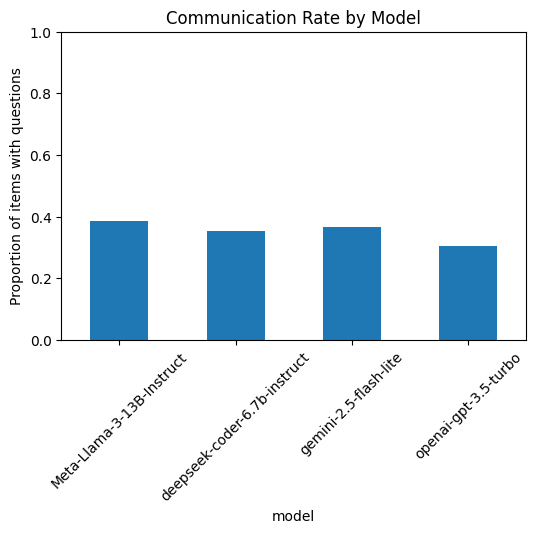

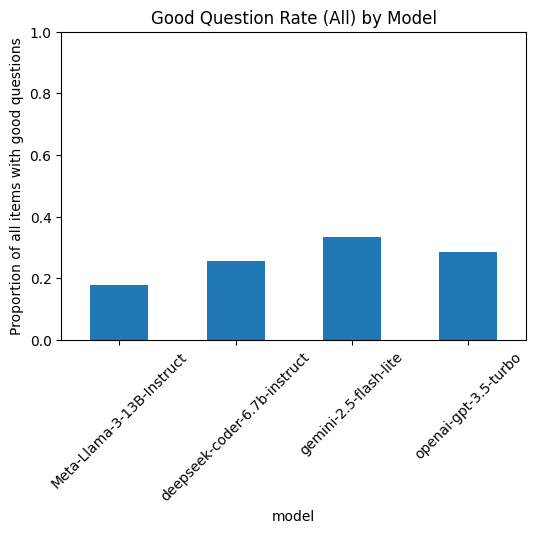

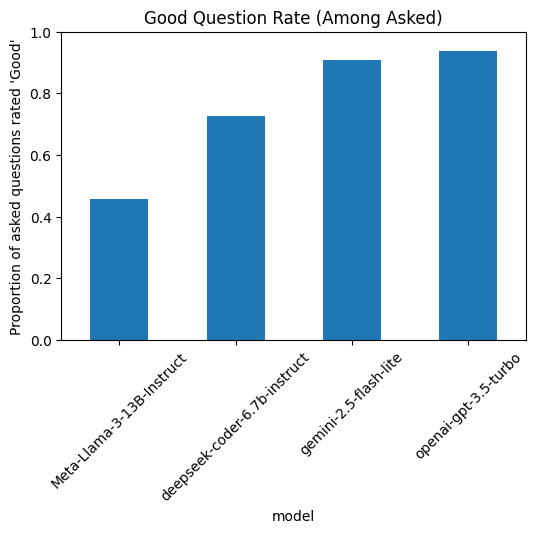

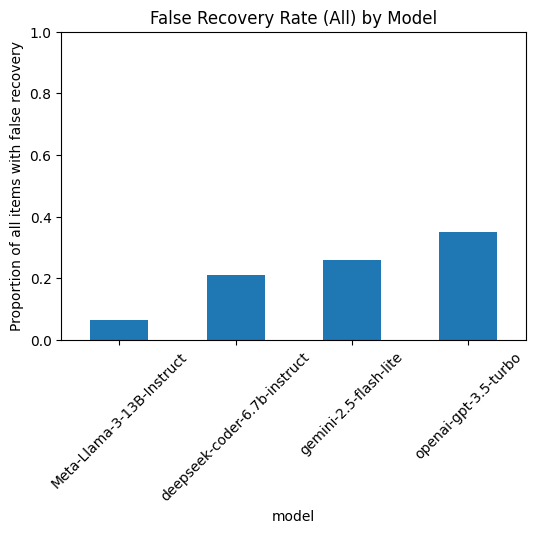

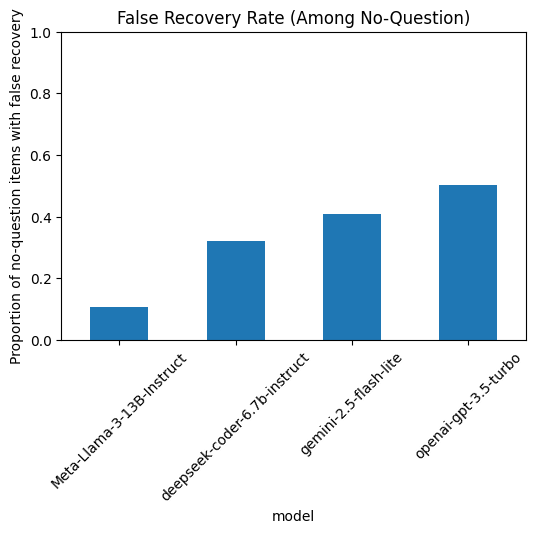

In [51]:

def save_bar(series: pd.Series, title: str, ylabel: str, out_path: Path):
    plt.figure(figsize=(6,4))
    series.plot(kind="bar")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.ylim(top=1)
    if SAVE_OUTPUTS:
        plt.savefig(out_path, dpi=100)
    plt.show()
    plt.close()

overall_sorted = metrics_overall.set_index("model")

save_bar(
    overall_sorted["communication_rate"],
    "Communication Rate by Model",
    "Proportion of items with questions",
    OUTDIR / "fig_comm_rate.png",
)

save_bar(
    overall_sorted["good_question_rate_all"],
    "Good Question Rate (All) by Model",
    "Proportion of all items with good questions",
    OUTDIR / "fig_gqr_all.png",
)

save_bar(
    overall_sorted["good_question_rate_conditional"],
    "Good Question Rate (Among Asked)",
    "Proportion of asked questions rated 'Good'",
    OUTDIR / "fig_gqr_conditional.png",
)

save_bar(
    overall_sorted["false_recovery_rate_all"],
    "False Recovery Rate (All) by Model",
    "Proportion of all items with false recovery",
    OUTDIR / "fig_frr_all.png",
)

save_bar(
    overall_sorted["false_recovery_rate_conditional"],
    "False Recovery Rate (Among No-Question)",
    "Proportion of no-question items with false recovery",
    OUTDIR / "fig_frr_conditional.png",
)



## Category × Model pivot tables
These are handy for appendices or heatmap-style inspection (no colors applied here).


In [41]:

pivot_cr = metrics_by_cat.pivot(index="category", columns="model", values="communication_rate")
pivot_gqr_all = metrics_by_cat.pivot(index="category", columns="model", values="good_question_rate_all")
pivot_frr_all = metrics_by_cat.pivot(index="category", columns="model", values="false_recovery_rate_all")

display(pivot_cr.head(20))
display(pivot_gqr_all.head(20))
display(pivot_frr_all.head(20))

if SAVE_OUTPUTS:
    (OUTDIR / "table_comm_rate_by_category.csv").write_text(pivot_cr.to_csv(), encoding="utf-8")
    (OUTDIR / "table_gqr_all_by_category.csv").write_text(pivot_gqr_all.to_csv(), encoding="utf-8")
    (OUTDIR / "table_frr_all_by_category.csv").write_text(pivot_frr_all.to_csv(), encoding="utf-8")


model,Meta-Llama-3-13B-Instruct,deepseek-coder-6.7b-instruct,gemini-2.5-flash-lite,openai-gpt-3.5-turbo
category,,,,
1a,0.359756,0.304878,0.347561,0.201220
1c,0.312883,0.276074,0.208589,0.116564
1p,0.353659,0.402439,0.384146,0.530488
2ac,0.450617,0.401235,0.469136,0.246914
2ap,0.549296,0.352113,0.577465,0.605634
2cp,0.342857,0.485714,0.257143,0.228571
3acp,0.416667,0.250000,0.250000,0.416667


model,Meta-Llama-3-13B-Instruct,deepseek-coder-6.7b-instruct,gemini-2.5-flash-lite,openai-gpt-3.5-turbo
category,,,,
1a,0.182927,0.225610,0.304878,0.182927
1c,0.116564,0.214724,0.165644,0.110429
1p,0.121951,0.304878,0.378049,0.500000
2ac,0.197531,0.271605,0.407407,0.228395
2ap,0.366197,0.281690,0.563380,0.563380
2cp,0.142857,0.257143,0.257143,0.228571
3acp,0.333333,0.166667,0.250000,0.416667


model,Meta-Llama-3-13B-Instruct,deepseek-coder-6.7b-instruct,gemini-2.5-flash-lite,openai-gpt-3.5-turbo
category,,,,
1a,0.042683,0.213415,0.335366,0.445122
1c,0.110429,0.276074,0.312883,0.466258
1p,0.079268,0.201220,0.201220,0.207317
2ac,0.037037,0.179012,0.209877,0.376543
2ap,0.028169,0.112676,0.126761,0.084507
2cp,0.114286,0.228571,0.371429,0.485714
3acp,0.000000,0.250000,0.416667,0.250000
